# Contents:

I. [Loading the Data:](#Loading-the-Data:)

II. [RFM Modeling:](#RFM-Modeling:)

III. [How RFM features helps in identifying the propensity to purchase of users?](#How-RFM-features-helps-in-identifying-the-propensity-to-purchase-of-users?)

## Loading the Data:

([Contents:](#Contents:))

In [1]:
# Importing the necessary Libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from datetime import timedelta

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Reading the data and changing the data type of the column "DateTime" from string to datetime format
data = pd.read_excel('data/final_customer_data.xlsx')
data['DateTime'] = pd.to_datetime(data['DateTime'])
print(data.shape)
data.head()

(2090, 9)


,User_id,Session_id,DateTime,Category,SubCategory,Action,Quantity,Rate,Total Price
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,Electronic Appliances,Speakers,first_app_open,NaN,NaN,NaN
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,Electronic Appliances,Speakers,search,NaN,NaN,NaN
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,Men's Fashion,Jeans,search,NaN,NaN,NaN
3,57314161118,90fc70-0e80-4590-96f3,2019-01-10 14:07:00,Men's Fashion,Jeans,product_view,NaN,NaN,NaN
4,57314161118,bd7419-2748-4c56-95b4,2019-01-10 14:12:00,Men's Fashion,Jeans,read_reviews,NaN,NaN,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2090 entries, 0 to 2089
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   User_id      2090 non-null   int64         
 1   Session_id   2090 non-null   object        
 2   DateTime     2090 non-null   datetime64[ns]
 3   Category     2090 non-null   object        
 4   SubCategory  2090 non-null   object        
 5   Action       2090 non-null   object        
 6   Quantity     201 non-null    float64       
 7   Rate         201 non-null    float64       
 8   Total Price  201 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 147.1+ KB


---

## RFM Modeling:

([Contents:](#Contents:))

To do the RFM analysis, we need to create 3 features from the data:
* **Recency**   - Latest date - Last invoice date. (Number of days since the last purchase date)
* **Frequency** - count of invoice numbers. (Total number of transactions made by a unique customer)
* **Monetary**  - Sum of Total sales. (Total value of transacted sales by each customer)

Now, let's create a function which can be used to generate the RFM features.

In [4]:
def RFM_Features(df, customerID, invoiceDate, transID, sales):
    ''' Create the Recency, Frequency, and Monetary features from the data '''
    
    # Calculate the latest date in the dataset and add one day to create the "latest_date"
    latest_date = df[invoiceDate].max() + timedelta(1)
    
    # Create RFM features by grouping the data by customerID and aggregating recency, frequency, and monetary values
    RFMScores = df.groupby(customerID).agg({
        invoiceDate: lambda x: (latest_date - x.max()).days,  # Calculate recency in days
        transID: lambda x: len(x),  # Count the number of transactions (frequency)
        sales: lambda x: sum(x)  # Calculate the sum of sales (monetary)
    })
    
    # Convert the recency (invoiceDate) to an integer since it represents the number of days
    RFMScores[invoiceDate] = RFMScores[invoiceDate].astype(int)
    
    # Rename the column names to Recency, Frequency, and Monetary
    RFMScores.rename(columns={
        invoiceDate: 'Recency',
        transID: 'Frequency',
        sales: 'Monetary'
    }, inplace=True)
    
    # Reset the index to make 'customerID' a regular column
    return RFMScores.reset_index()


In [5]:
# Calculate RFM features for purchase-related data in the 'data' DataFrame
RFM = RFM_Features(
    df=data[data['Action'] == 'purchase'],  # Filter data for 'purchase' actions
    customerID="User_id",  # Identify customers by 'User_id'
    invoiceDate="DateTime",  # Use 'DateTime' as the invoice date
    transID="Session_id",  # Count transactions using 'Session_id'
    sales="Total Price"  # Calculate monetary value using 'Total Price'
)

# Print the shape (number of rows and columns) of the resulting RFM DataFrame
print(RFM.shape)

# Display the first few rows of the RFM DataFrame
RFM.head()


(167, 4)


,User_id,Recency,Frequency,Monetary
0,51448162784,10,2,21500.0
1,51455512201,64,1,10000.0
2,51462598385,7,2,550.0
3,51463622150,40,2,950.0
4,51465529647,10,2,15500.0


,Recency,Frequency,Monetary
count,167.000000,167.000000,167.000000
mean,112.263473,1.203593,11380.419162
std,91.085568,0.432685,20236.203462
min,1.000000,1.000000,150.000000
25%,41.500000,1.000000,1575.000000
50%,72.000000,1.000000,3000.000000
75%,164.000000,1.000000,10700.000000
max,345.000000,3.000000,160000.000000


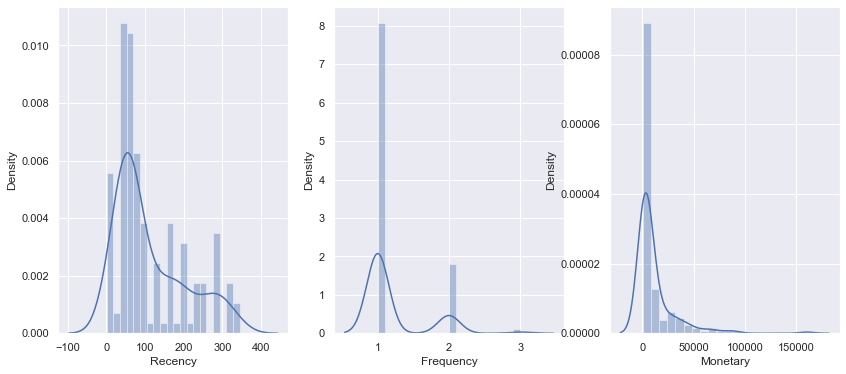

In [6]:
# Display summary statistics of the RFM features (excluding 'User_id')
display(RFM.drop('User_id', axis=1).describe())

# Create subplots for Recency, Frequency, and Monetary feature distributions
fig, ax = plt.subplots(1, 3, figsize=(14, 6))

# Plot the distribution of the Recency feature
sns.distplot(RFM.Recency, bins=20, ax=ax[0])

# Plot the distribution of the Frequency feature
sns.distplot(RFM['Frequency'], bins=20, ax=ax[1])

# Plot the distribution of the Monetary feature
sns.distplot(RFM['Monetary'], bins=20, ax=ax[2])

# Display the histograms for the features
plt.show()


To conduct RFM analysis, we need to rank the customers based on each RFM attribute separately.

Assume that we rank these customers from 1-4 using RFM values. (1-low score & 4-High score)

**Steps to be followed for RFM ranking:**
1. Sort the Recency column by **most recent purchases at the top.** For Frequency and Monetary features sort it by the **most frequent** and **most valuable** purchases at the top.
2. If you are using N-scale ranking to rank the customers then you have to divide the sorted values of the features into 1/N groups. Here, we are using 4-scale ranking hence we need to divide the values into 4 groups.

we can do both the sorting and grouping using pandas **df.quantile** method by providing the number of quantiles as a list.





**NOTE:** The value of N decides the number of different RFM rank groups you want to create. All possible combination of ranks from 1-N for all the three RFM features results in N^3 rank groups ranging from 111(lowest) to NNN(highest).

In our case N=4, hence we could have a maximum of 4^3 = 64 rank groups with scores from 111 to 444.

In [7]:
# Calculate and display the 25th, 50th (median), and 75th percentiles for the 'Recency,' 'Frequency,' and 'Monetary' columns
RFM[['Recency', 'Frequency', 'Monetary']].quantile([0.25, 0.50, 0.75])


,Recency,Frequency,Monetary
0.25,41.5,1.0,1575.0
0.50,72.0,1.0,3000.0
0.75,164.0,1.0,10700.0


In [8]:
# Calculate and store the 25th, 50th (median), and 75th percentiles for 'Recency,' 'Frequency,' and 'Monetary' columns in a dictionary
Quantiles = RFM[['Recency', 'Frequency', 'Monetary']].quantile([0.25, 0.50, 0.75])
Quantiles = Quantiles.to_dict()
Quantiles


{'Recency': {0.25: 41.5, 0.5: 72.0, 0.75: 164.0},
 'Frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'Monetary': {0.25: 1575.0, 0.5: 3000.0, 0.75: 10700.0}}

In [9]:
def RFMRanking(x, variable, quantile_dict):
    ''' Ranking the Recency, Frequency, and Monetary features based on quantile values '''
    
    # Checking if the feature to rank is Recency
    if variable == 'Recency':
        if x <= quantile_dict[variable][0.25]:
            return 4
        elif (x > quantile_dict[variable][0.25]) & (x <= quantile_dict[variable][0.5]):
            return 3
        elif (x > quantile_dict[variable][0.5]) & (x <= quantile_dict[variable][0.75]):
            return 2
        else:
            return 1
    
    # Checking if the feature to rank is Frequency and Monetary
    if variable in ('Frequency', 'Monetary'):
        if x <= quantile_dict[variable][0.25]:
            return 1
        elif (x > quantile_dict[variable][0.25]) & (x <= quantile_dict[variable][0.5]):
            return 2
        elif (x > quantile_dict[variable][0.5]) & (x <= quantile_dict[variable][0.75]):
            return 3
        else:
            return 4


In [10]:
# Assign Recency rankings to the 'R' column
RFM['R'] = RFM['Recency'].apply(lambda x: RFMRanking(x, variable='Recency', quantile_dict=Quantiles))

# Assign Frequency rankings to the 'F' column
RFM['F'] = RFM['Frequency'].apply(lambda x: RFMRanking(x, variable='Frequency', quantile_dict=Quantiles))

# Assign Monetary rankings to the 'M' column
RFM['M'] = RFM['Monetary'].apply(lambda x: RFMRanking(x, variable='Monetary', quantile_dict=Quantiles))


In [11]:
print(RFM.shape)
RFM.head()

(167, 7)


,User_id,Recency,Frequency,Monetary,R,F,M
0,51448162784,10,2,21500.0,4,4,4
1,51455512201,64,1,10000.0,3,1,3
2,51462598385,7,2,550.0,4,4,1
3,51463622150,40,2,950.0,4,4,1
4,51465529647,10,2,15500.0,4,4,4


In [12]:
# Create a new 'Group' column by concatenating the 'R,' 'F,' and 'M' rankings as strings
RFM['Group'] = RFM['R'].apply(str) + RFM['F'].apply(str) + RFM['M'].apply(str)

# Display the first few rows of the updated RFM DataFrame
RFM.head()


,User_id,Recency,Frequency,Monetary,R,F,M,Group
0,51448162784,10,2,21500.0,4,4,4,444
1,51455512201,64,1,10000.0,3,1,3,313
2,51462598385,7,2,550.0,4,4,1,441
3,51463622150,40,2,950.0,4,4,1,441
4,51465529647,10,2,15500.0,4,4,4,444


In [13]:
# Calculate the RFM score by summing the values in the 'R,' 'F,' and 'M' columns for each customer
RFM["Score"] = RFM[['R', 'F', 'M']].sum(axis=1)

# Display the first few rows of the updated RFM DataFrame
RFM.head()


,User_id,Recency,Frequency,Monetary,R,F,M,Group,Score
0,51448162784,10,2,21500.0,4,4,4,444,12
1,51455512201,64,1,10000.0,3,1,3,313,7
2,51462598385,7,2,550.0,4,4,1,441,9
3,51463622150,40,2,950.0,4,4,1,441,9
4,51465529647,10,2,15500.0,4,4,4,444,12


In [14]:
# Define loyalty levels: 'Bronze,' 'Silver,' 'Gold,' 'Platinum'
loyalty = ['Bronze', 'Silver', 'Gold', 'Platinum']

# Assign loyalty levels based on RFM score, where 'q=4' indicates four quantiles
RFM['Loyalty_Level'] = pd.qcut(RFM['Score'], q=4, labels=loyalty)

# Display the first few rows of the updated RFM DataFrame with loyalty levels
RFM.head()


,User_id,Recency,Frequency,Monetary,R,F,M,Group,Score,Loyalty_Level
0,51448162784,10,2,21500.0,4,4,4,444,12,Platinum
1,51455512201,64,1,10000.0,3,1,3,313,7,Gold
2,51462598385,7,2,550.0,4,4,1,441,9,Platinum
3,51463622150,40,2,950.0,4,4,1,441,9,Platinum
4,51465529647,10,2,15500.0,4,4,4,444,12,Platinum


In [15]:
# Group the RFM DataFrame by 'Loyalty_Level' and calculate the mean values for specified columns
behaviour = RFM.groupby('Loyalty_Level')[['Recency', 'Frequency', 'Monetary', 'Score']].mean()

# Display the mean behavior for each loyalty level
behaviour


,Recency,Frequency,Monetary,Score
Loyalty_Level,,,,
Bronze,188.054545,1.000000,2436.363636,4.290909
Silver,102.813953,1.000000,7777.441860,6.000000
Gold,56.064516,1.032258,24183.870968,7.645161
Platinum,59.105263,1.868421,17957.894737,9.947368


In [16]:
RFM.shape

(167, 10)

---

## How RFM features helps in identifying the propensity to purchase of users?

([Contents:](#Contents:))

There are two broad ways in which the RFM features can be utilized:
* **Preferrential Treatments:** RFM features and loyalty tags will be available only for existing users. So, whenever old users shows interest in any product, based on their loyalty tags we can target them with personalized discounts etc.


* **High value path:** We can analyze the behaviour exhibited by the old users and create multiple behaviour paths that leads to increased purchase. This learning can then be used to nudge new users to follow such paths and hence increase the probability of purchase.

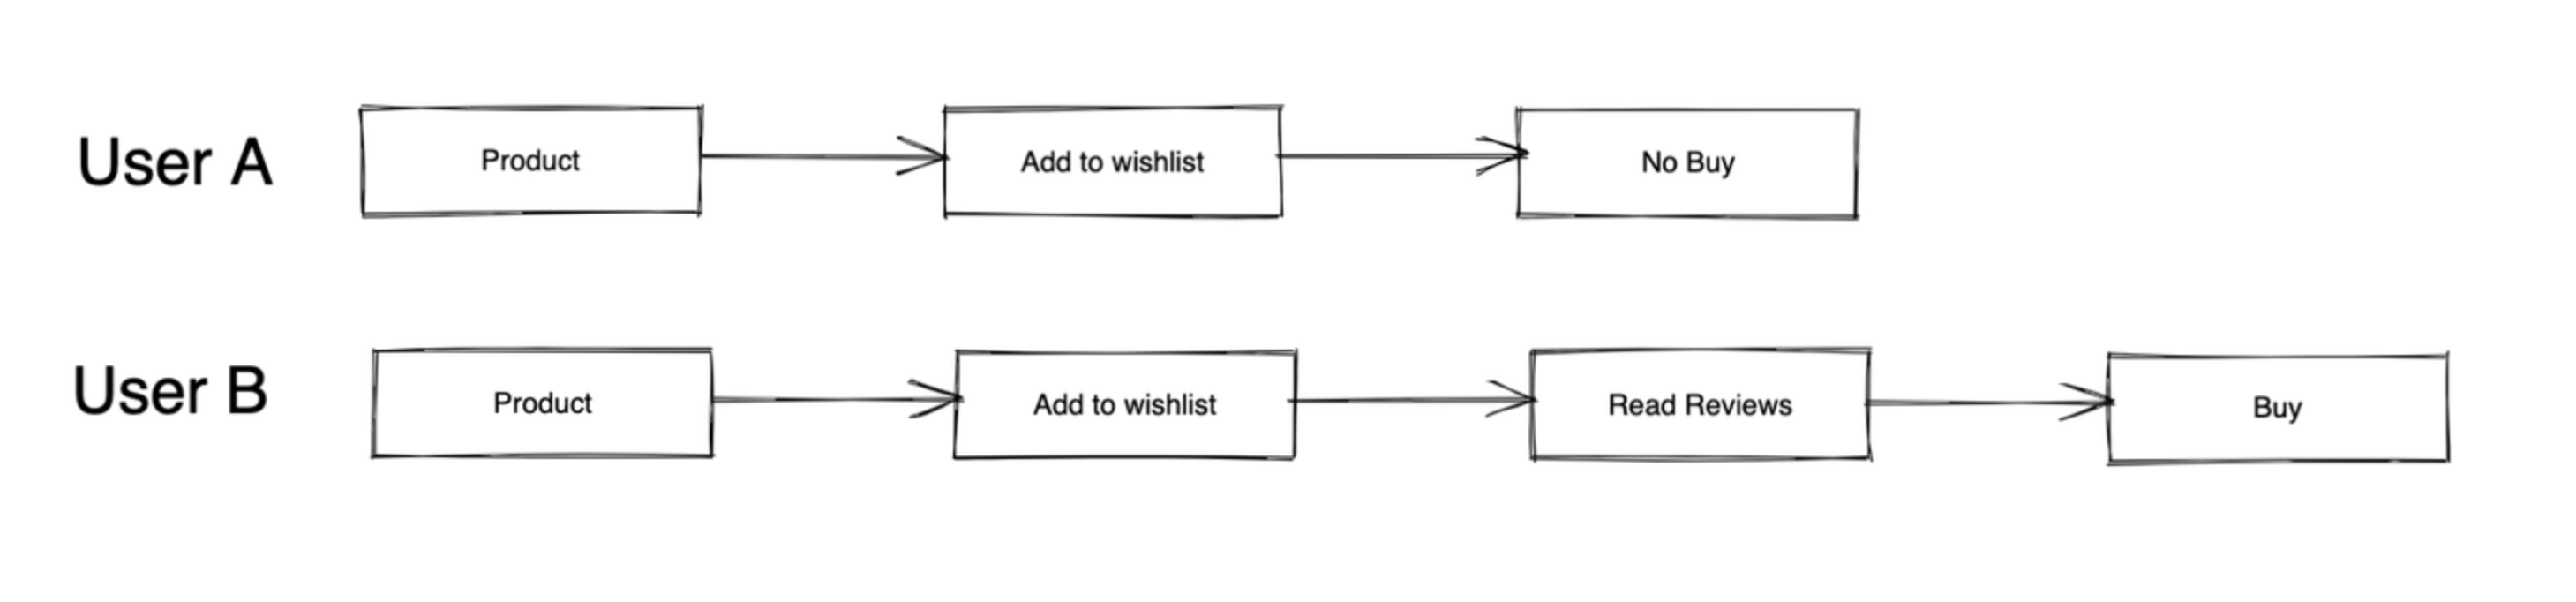

Adding the RFM features to the base dataset.

In [17]:
# Read data from an Excel file and change the data type of the 'DateTime' column to datetime format
data = pd.read_excel('data/final_customer_data.xlsx')
data['DateTime'] = pd.to_datetime(data['DateTime'])

# Print the shape (number of rows and columns) of the DataFrame
print(data.shape)

# Display the first few rows of the updated DataFrame
data.head()


(2090, 9)


,User_id,Session_id,DateTime,Category,SubCategory,Action,Quantity,Rate,Total Price
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,Electronic Appliances,Speakers,first_app_open,NaN,NaN,NaN
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,Electronic Appliances,Speakers,search,NaN,NaN,NaN
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,Men's Fashion,Jeans,search,NaN,NaN,NaN
3,57314161118,90fc70-0e80-4590-96f3,2019-01-10 14:07:00,Men's Fashion,Jeans,product_view,NaN,NaN,NaN
4,57314161118,bd7419-2748-4c56-95b4,2019-01-10 14:12:00,Men's Fashion,Jeans,read_reviews,NaN,NaN,NaN


In [18]:
# Merge the 'data' DataFrame with the 'RFM' DataFrame based on the 'User_id' column using a left join
data_with_RFM = pd.merge(data, RFM, on='User_id', how='left')

# Print the shape (number of rows and columns) of the merged DataFrame
print(data_with_RFM.shape)

# Display the first few rows of the merged DataFrame
data_with_RFM.head()


(2090, 18)


,User_id,Session_id,DateTime,Category,SubCategory,Action,Quantity,Rate,Total Price,Recency,Frequency,Monetary,R,F,M,Group,Score,Loyalty_Level
0,52243841613,d76fde-8bb3-4e00-8c23,2019-01-10 10:20:00,Electronic Appliances,Speakers,first_app_open,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,52243841613,33dfbd-b87a-4708-9857,2019-01-10 10:22:00,Electronic Appliances,Speakers,search,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,57314161118,6511c2-e2e3-422b-b695,2019-01-10 14:00:00,Men's Fashion,Jeans,search,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,57314161118,90fc70-0e80-4590-96f3,2019-01-10 14:07:00,Men's Fashion,Jeans,product_view,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,57314161118,bd7419-2748-4c56-95b4,2019-01-10 14:12:00,Men's Fashion,Jeans,read_reviews,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
data_with_RFM.isna().sum()

User_id             0
Session_id          0
DateTime            0
Category            0
SubCategory         0
Action              0
Quantity         1889
Rate             1889
Total Price      1889
Recency           787
Frequency         787
Monetary          787
R                 787
F                 787
M                 787
Group             787
Score             787
Loyalty_Level     787
dtype: int64

In [ ]:
# data_with_RFM.to_csv("data/final_customer_data_with_RFM_features.csv",index=False)

---